In [1]:
import pandas as pd
products = pd.read_csv('./data/modesens_products_sample_cleaned.csv')
outfits = pd.read_csv('./data/outfits.csv')

In [3]:
! pip install pandarallel

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.6 MB/s eta 0:00:000:00:010:00:01
  DEPRECATION: pandarallel is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for pandarallel ... done

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# products['title_embed'] = products['title'].apply(lambda x: list(model.encode(str(x))))
# apply multi-threads
# from pandarallel import pandarallel
# pandarallel.initialize()
# products['keywords_embed'] = products['fashion_keywords'].parallel_apply(lambda x: list(model.encode(str(x))))
products['keywords_embed'] = products['fashion_keywords'].apply(lambda x: list(model.encode(str(x))))

products.to_csv('./data/modesens_products_sample_cleaned_embed.csv', index=False)

/Users/frankchang/.pyenv/versions/3.11.3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(products.loc[0, "keywords_embed"])

384

In [4]:
outfits.loc[20, "outfit"].split("\n")

['Top: Bomber jacket or a varsity jacket.',
 'Layering: Plain or striped t-shirt.',
 'Bottom: Baggy jeans or cargo pants.',
 'Footwear: High-top sneakers or boots.',
 'Accessories: Baseball cap worn backward, a chain necklace, and a beanie.']

In [5]:
products.main_category.unique()

array(['outerwear', 'tops', 'bottoms', 'accessories', 'clothing',
       'footwear'], dtype=object)

In [6]:
products.sub_category.unique()

array(['casual jackets', 'shirts', 'pants', 'bags', 'clothing', 'shoes',
       'headwear', 'belts', 'vests', 'ties', 'jewelry', 'shorts',
       'accessories', 'socks', 'gloves', 'activewear'], dtype=object)

In [7]:
# 1. Get the description from outfit dataset
# 2. For each category in such outfit, conduct embedding search on the product descriptions
# 3. Get the top 10 products for each category

# Path: whole_pipeline.ipynb
from collections import defaultdict
import numpy as np
from scipy.spatial.distance import cosine

def get_top_k_products(outfit_dict, k=4):
    top_k_products = defaultdict(list)
    for category, description in outfit_dict.items():
        category_descrip_embed = model.encode(description)
        category_descrip_embed = np.squeeze(category_descrip_embed)
        products_tmp = products[products.main_category == category]

        for index, row in products_tmp.iterrows():
            product_descrip_embed = row["keywords_embed"]
            product_descrip_embed = np.squeeze(product_descrip_embed)
            score = cosine(category_descrip_embed, product_descrip_embed)
            top_k_products[category].append((index, score))
        
        top_k_products[category] = sorted(top_k_products[category], key=lambda x: x[1])[:k][::-1]
    return top_k_products

In [8]:
! pip install matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import requests

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


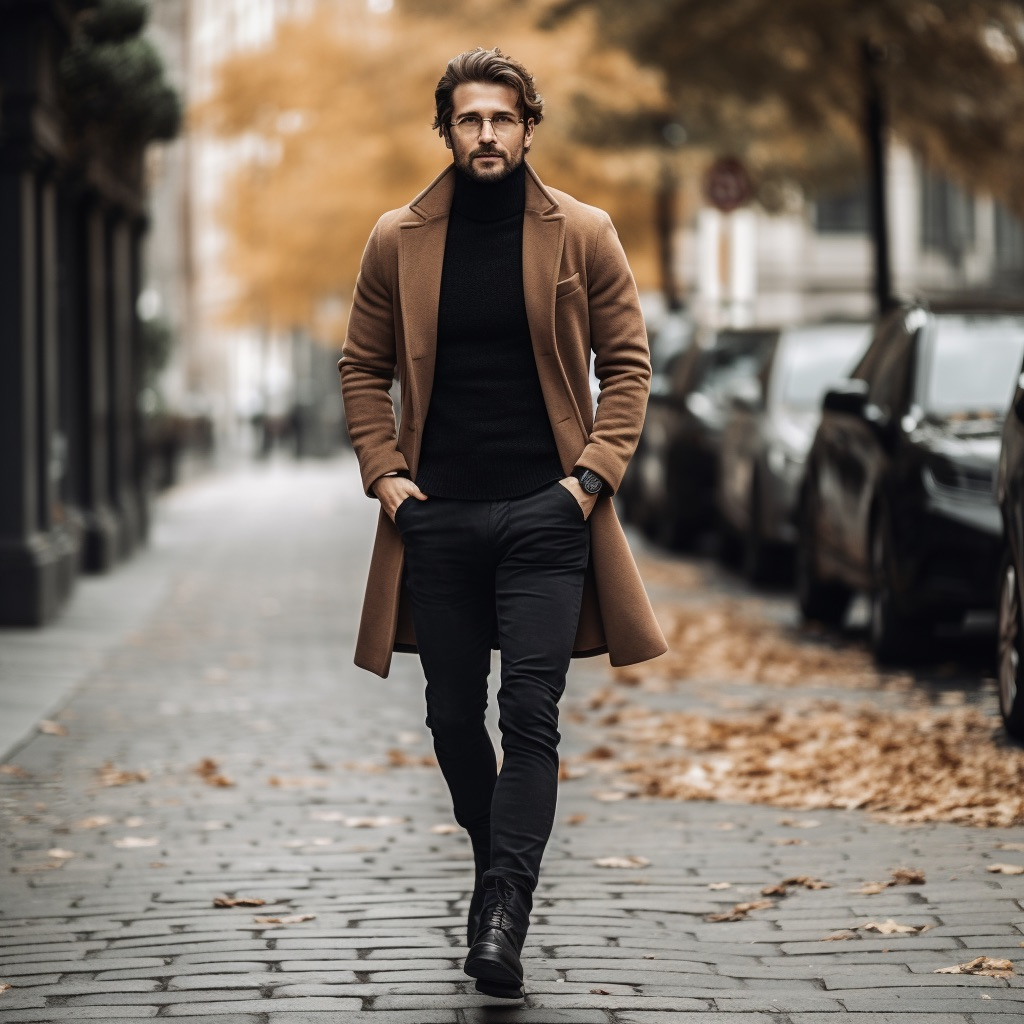

In [9]:
url = outfits.loc[9,'outfit_image']
image = Image.open(requests.get(url, stream=True).raw)
display(image)

In [75]:
outfits.loc[9,'outfit']

'Tops: A fitted black turtleneck.\nBottoms: Slim-fit dark indigo jeans.\nShoes: Brown leather Chelsea boots.\nAccessories: A camel-colored wool coat, a leather belt, and a minimalistic wristwatch.'

In [10]:
def process_outfit(outfit):
    outfit_dict = defaultdict(list)
    for item in outfit.split("\n"):
        category, description = item.split(":")
        category = category.strip().lower()
        outfit_dict[category] = description.strip()
    return outfit_dict

outfit_dict = process_outfit(outfits.loc[9, "outfit"])
top_k_products = get_top_k_products(outfit_dict, k=4)

tops
A fitted black turtleneck.


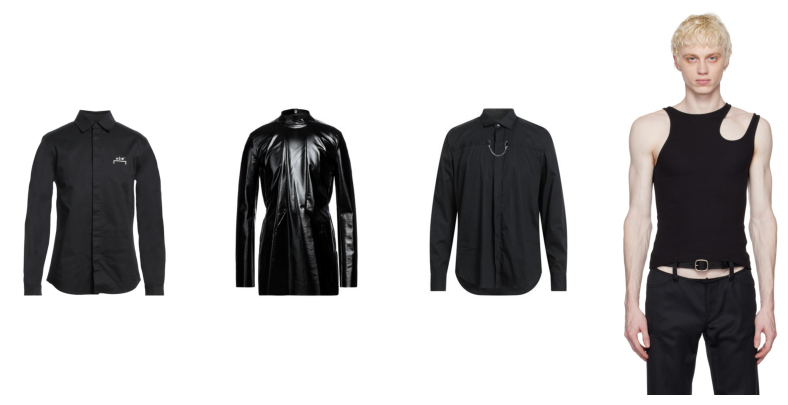

bottoms
Slim-fit dark indigo jeans.
link expired:  https://imagescdn.simons.ca/images/16970/23101/1/A1_1.jpg?__=3


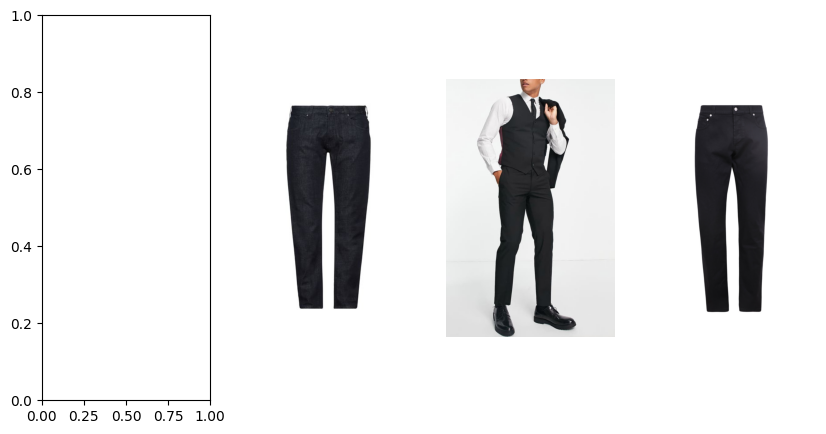

footwear
Brown leather Chelsea boots.
link expired:  https://www.yoox.com/images/items/11/11940169vk_12_f.jpg


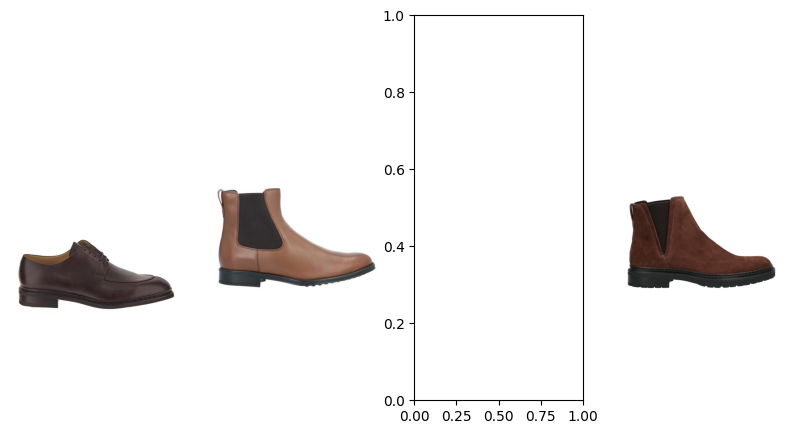

accessories
A camel-colored wool coat, a leather belt, and a minimalistic wristwatch.


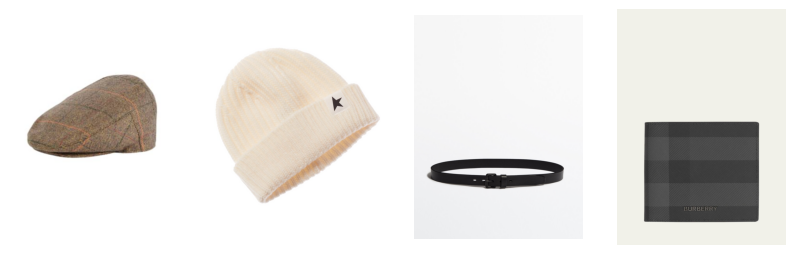

In [11]:
k = 4
for category, products_indices in top_k_products.items():
    print(category)
    print(outfit_dict[category])
    fig = plt.figure(figsize=(10, 5))
    for i in range(k):
        try:
            fig.add_subplot(1, k, i+1)
            url = products.loc[products_indices[i][0],'image_link']
            im = Image.open(requests.get(url,stream=True,timeout=(10, 20)).raw)

            # showing image
            plt.imshow(im)
            plt.axis('off')
        except:
            print('link expired: ', url)
    plt.show()

In [12]:
top_k_products

defaultdict(list,
            {'tops': [(3008, 0.393413782119751),
              (9137, 0.38905149698257446),
              (1458, 0.37928056716918945),
              (2646, 0.357768714427948)],
             'bottoms': [(6365, 0.3376615643501282),
              (9131, 0.3208777904510498),
              (7308, 0.3194150924682617),
              (4836, 0.272638738155365)],
             'footwear': [(1084, 0.2521206736564636),
              (3773, 0.24820280075073242),
              (3438, 0.24820280075073242),
              (3368, 0.23416149616241455)],
             'accessories': [(3538, 0.32435405254364014),
              (8799, 0.3187698721885681),
              (5672, 0.3168473243713379),
              (40, 0.29675769805908203)]})

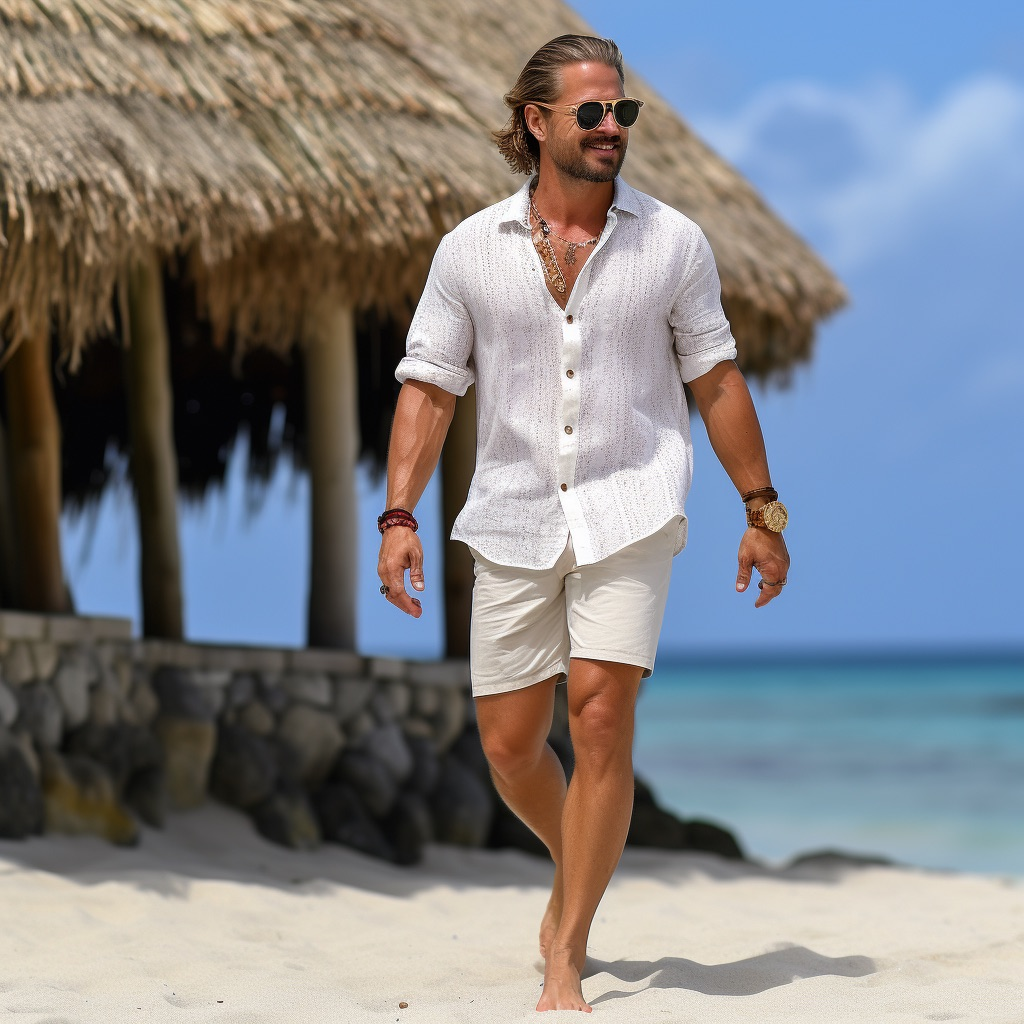

In [13]:
url = outfits.loc[12,'outfit_image']
image = Image.open(requests.get(url, stream=True).raw)
display(image)

In [14]:
outfit_dict = process_outfit(outfits.loc[12, "outfit"])
top_k_products = get_top_k_products(outfit_dict, k=4)

tops
A loose-fitting white linen button-up shirt, left unbuttoned.


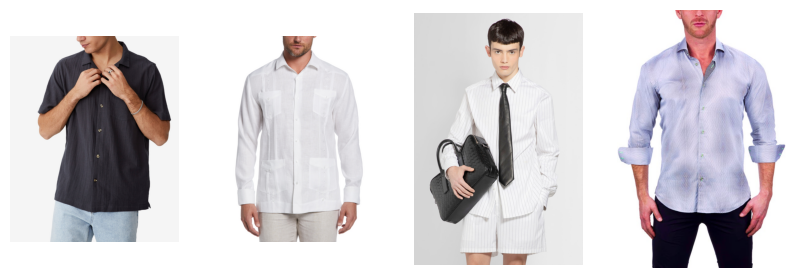

bottoms
Light blue or white board shorts.
link expired:  https://cdn.shopify.com/s/files/1/0274/7695/1137/products/62d3f02f3fd3b8f9cf3f5f9773d7b572.jpg


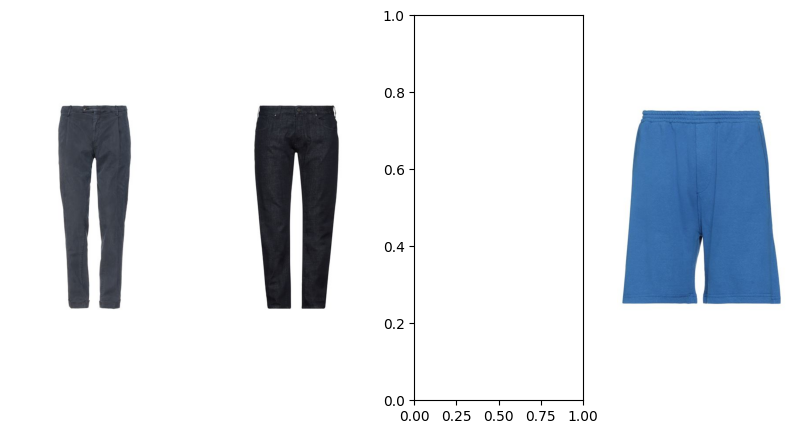

footwear
Flip-flops or casual slip-on sandals.


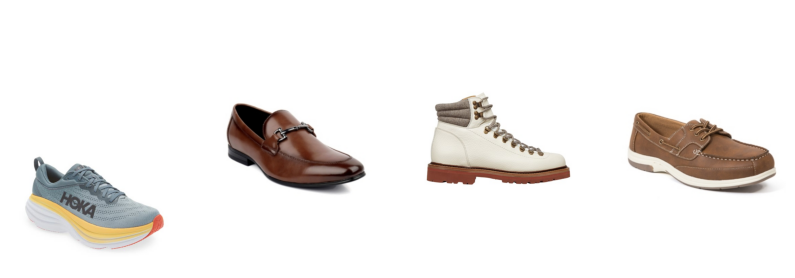

accessories
A woven straw hat, a colorful beaded bracelet, and polarized sunglasses.


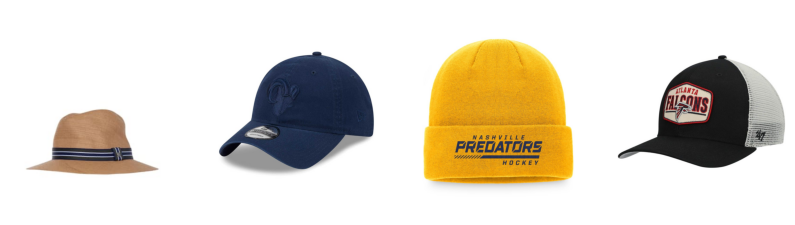

In [15]:
k = 4
for category, products_indices in top_k_products.items():
    print(category)
    print(outfit_dict[category])
    fig = plt.figure(figsize=(10, 5))
    for i in range(k):
        try:
            fig.add_subplot(1, k, i+1)
            url = products.loc[products_indices[i][0],'image_link']
            im = Image.open(requests.get(url,stream=True,timeout=(10, 20)).raw)

            # showing image
            plt.imshow(im)
            plt.axis('off')
        except:
            print('link expired: ', url)
    plt.show()

In [16]:
top_k_products

defaultdict(list,
            {'tops': [(8265, 0.22352510690689087),
              (9490, 0.21679973602294922),
              (409, 0.20634669065475464),
              (2864, 0.2044317126274109)],
             'bottoms': [(3731, 0.39988404512405396),
              (9131, 0.3820977210998535),
              (1754, 0.3649190068244934),
              (1462, 0.35411715507507324)],
             'footwear': [(8918, 0.392905592918396),
              (9068, 0.38970357179641724),
              (1414, 0.3673763871192932),
              (3339, 0.34465986490249634)],
             'accessories': [(5174, 0.24276387691497803),
              (581, 0.23482519388198853),
              (4114, 0.22131961584091187),
              (5938, 0.21144384145736694)]})

### How to improve in the next setp
1. extract keywords from the parsed query
2. 